In [1]:
import random
import torch
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from termcolor import colored, cprint
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
import torch.nn as nn

In [36]:
# Hyperparameters
opts = {}

# Data settings
opts['num_train_samples']=10000
opts['num_test_samples']=1000
opts['batch_size']=20
opts['num_gaussians']=2
opts['gauss_weights']=None
opts['gap']=10

# Model and learning settings
opts['hidden_layer_size']=50
opts['learning_rate']=1e-4
opts['epochs']=100

# Get data

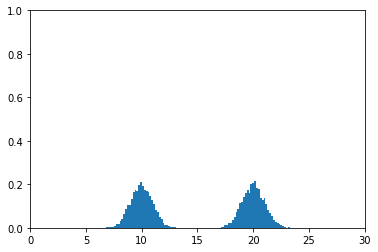

In [53]:
def unconditional_gaussian_mixture(num_gaussians, gap, num_samples, batch_size, weights=None):    
    # Creating gaussians
    gaussians = []
    for n in range(num_gaussians):
        gauss = norm(loc=(n+1)*gap)
        gaussians.append(gauss)

    # Sampling
    data = []  # Each sample will be (x, [y, y', ...])
    num_batches = int(num_samples/batch_size) + 1
    for batch_i in range(num_batches):
        x = [1.]
        Y = []
        for sample_i in range(batch_size):
            gauss = np.random.choice(gaussians, p=weights)
            Y.append(gauss.rvs(size=1)[0])
        data.append((x, Y))    
    return gaussians, data

gaussians, train_data = unconditional_gaussian_mixture(opts['num_gaussians'], opts['gap'], opts['num_train_samples'], opts['batch_size'])
_, test_data = unconditional_gaussian_mixture(opts['num_gaussians'], opts['gap'], opts['num_test_samples'], opts['batch_size'])

# Plot Gaussians
fig, ax = plt.subplots()
# plt.title('Data Histogram')
# plt.axis([0, (len(gaussians)+1)*opts['gap'],0,1])
# plt.ylabel('%')
# x = np.arange(0, (len(gaussians)+1)*opts['gap'], 1)
# for gauss in gaussians:
#     ax.plot(x, gauss.pdf(x))
# Plot data
plt.axis([0, (len(gaussians)+1)*opts['gap'], 0, 1])
sample_Y = [y for sample in train_data for y in sample[1]]
h = ax.hist(sample_Y, bins=100, density=True)

# Model and losses

In [38]:
# Define simple neural net
def get_new_model():
    model = torch.nn.Sequential(
    torch.nn.Linear(1, opts['hidden_layer_size']),
    torch.nn.ReLU(),
    torch.nn.Linear(int(opts['hidden_layer_size']), 1),
    )
    return model

In [39]:
# Write and loss,or loss
class StandardLossDefiner(torch.nn.Module):
    def __init__(self):
        super(StandardLossDefiner, self).__init__()
        self.loss_function = nn.MSELoss(reduction='elementwise_mean')

    def forward(self, pred, targets):
        return self.loss_function(pred.expand(opts['batch_size']),targets) # avg in log space (all y)

    
class SumLossDefiner(torch.nn.Module):
    def __init__(self):
        super(SumLossDefiner, self).__init__()
        self.loss_function = nn.MSELoss(reduction='none')

    def forward(self, pred, targets):
        losses = self.loss_function(pred.expand(opts['batch_size']),targets)
        Y_loss = torch.logsumexp(losses, dim=0)/opts['batch_size'] # avg in non log-space (any y in Y)
        return Y_loss
    
class MaxLossDefiner(torch.nn.Module):
    def __init__(self):
        super(MaxLossDefiner, self).__init__()
        self.loss_function = nn.MSELoss(reduction='none')

    def forward(self, pred, targets):
        losses = self.loss_function(pred.expand(opts['batch_size']),targets)
        Y_loss = torch.min(losses, dim=0)[0] # min (any y in Y)
        return Y_loss
    
standard_criterion = StandardLossDefiner()
sum_criterion = SumLossDefiner()
max_criterion = MaxLossDefiner()

# Train and test

In [40]:
def prep(li):
    return torch.FloatTensor(li) # e.g. x=[1.]

print('sample:',prep(train_data[0][0]))

sample: tensor([1.])


In [54]:
def train_and_test(criterion):
    optimizer = torch.optim.Adam(model.parameters(), lr=opts['learning_rate'])
    for epoch in range(opts['epochs']):
        # Train
        epoch_loss=0.0
        for (x,Y) in train_data:
            # Forward pass: compute predicted y
            pred = model(prep(x))
            loss = criterion(pred, prep(Y))
            # Backward pass: compute gradient of the loss with respect to model
            optimizer.zero_grad()
            loss.backward() 
            optimizer.step()
            # Stats
            epoch_loss += loss.item()
        
        if epoch%5 == 0:
            # Predict
            predictions = []
            for (x,Y) in test_data:
                prediction = model(prep(x)).item()
                predictions.append(prediction)
            
            # Report
            print('Epoch %d loss:%.3f predicts(mean):%f' % (epoch, epoch_loss, sum(predictions)/len(predictions)))
            fig, ax = plt.subplots()
#             plt.title('Epoch %d predictions' % (epoch))
#             plt.ylabel('%')
            plt.axis([0, (len(gaussians)+1)*opts['gap'], 0, 1])
#             # Plot Gaussians
#             x = np.arange(0, (opts['num_gaussians']+1)*opts['gap'], .1)
#             for gauss in gaussians:
#                 ax.plot(x, gauss.pdf(x))
            # Plot predictions
            sample_Y = [y for sample in train_data for y in sample[1]]
            f = ax.hist(sample_Y, bins=100, density=True)
            h = ax.hist(predictions, density=True)

            
    return

In [55]:
model = get_new_model()

Epoch 0 loss:32479.311 predicts(mean):1.004100
Epoch 5 loss:1645.833 predicts(mean):7.340429
Epoch 10 loss:31.816 predicts(mean):9.115390
Epoch 15 loss:15.221 predicts(mean):9.608203
Epoch 20 loss:14.356 predicts(mean):9.799753
Epoch 25 loss:14.447 predicts(mean):9.799239
Epoch 30 loss:14.447 predicts(mean):9.799197
Epoch 35 loss:14.447 predicts(mean):9.799193
Epoch 40 loss:14.447 predicts(mean):9.799192
Epoch 45 loss:14.447 predicts(mean):9.799193
Epoch 50 loss:14.446 predicts(mean):9.799192
Epoch 55 loss:14.446 predicts(mean):9.799193
Epoch 60 loss:14.446 predicts(mean):9.799193
Epoch 65 loss:14.446 predicts(mean):9.799193
Epoch 70 loss:14.447 predicts(mean):9.799193
Epoch 75 loss:14.446 predicts(mean):9.799193
Epoch 80 loss:14.447 predicts(mean):9.799193
Epoch 85 loss:14.446 predicts(mean):9.799193
Epoch 90 loss:14.446 predicts(mean):9.799194
Epoch 95 loss:14.447 predicts(mean):9.799194


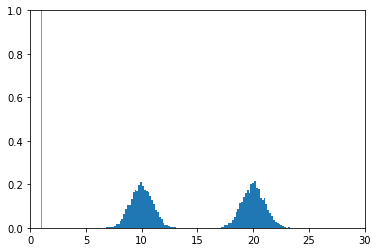

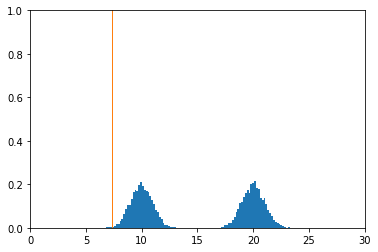

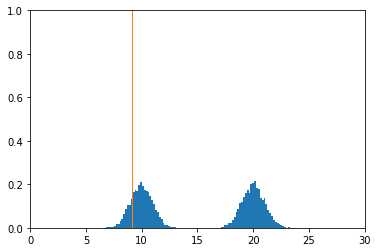

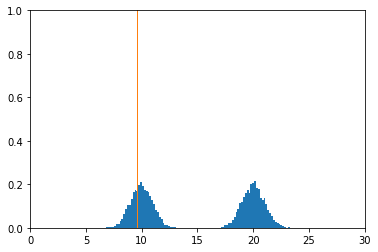

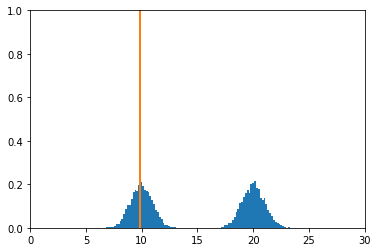

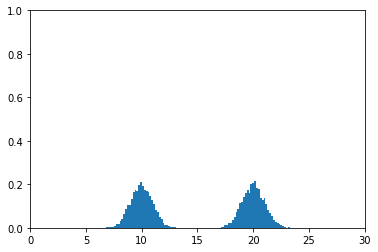

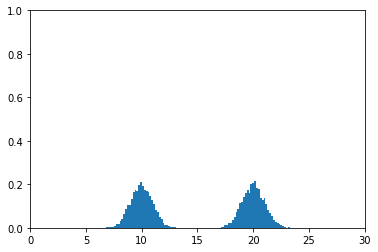

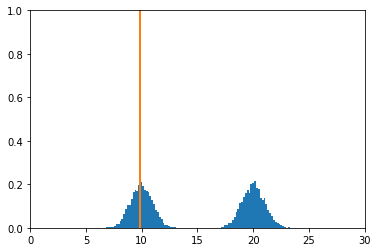

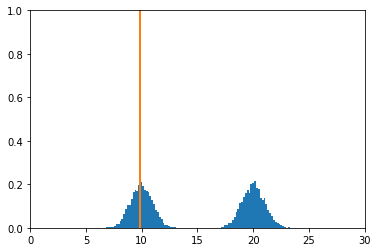

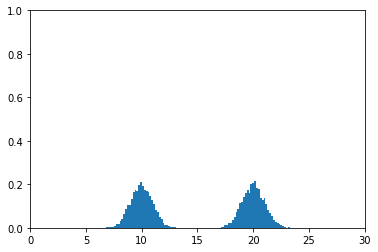

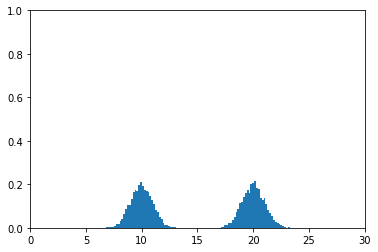

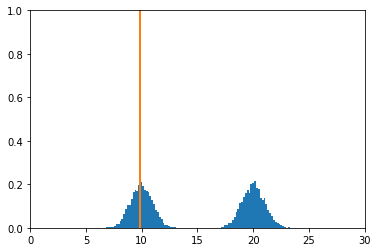

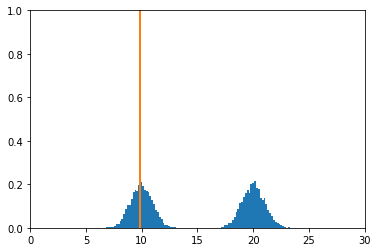

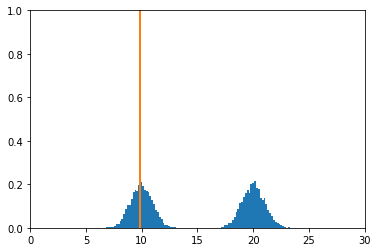

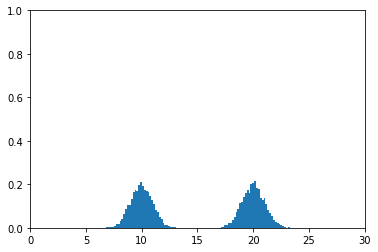

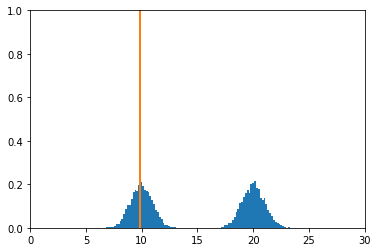

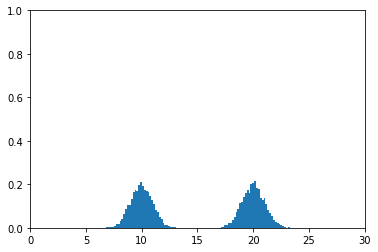

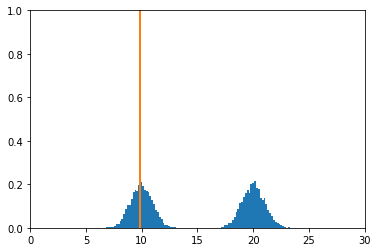

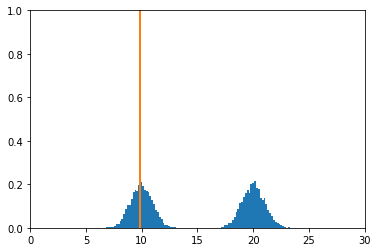

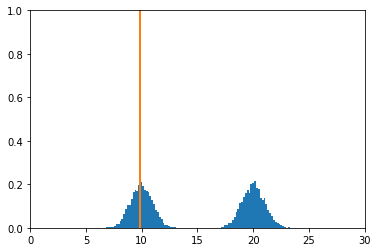

In [56]:
train_and_test(max_criterion)

In [57]:
model = get_new_model()

Epoch 0 loss:116110.370 predicts(mean):1.378999
Epoch 5 loss:25932.130 predicts(mean):11.011772
Epoch 10 loss:13093.544 predicts(mean):15.024820
Epoch 15 loss:13091.677 predicts(mean):15.052821
Epoch 20 loss:13091.893 predicts(mean):15.052465
Epoch 25 loss:13091.914 predicts(mean):15.052426
Epoch 30 loss:13091.916 predicts(mean):15.052424
Epoch 35 loss:13091.916 predicts(mean):15.052423
Epoch 40 loss:13091.916 predicts(mean):15.052423
Epoch 45 loss:13091.916 predicts(mean):15.052423
Epoch 50 loss:13091.916 predicts(mean):15.052423
Epoch 55 loss:13091.916 predicts(mean):15.052424
Epoch 60 loss:13091.916 predicts(mean):15.052423
Epoch 65 loss:13091.916 predicts(mean):15.052424
Epoch 70 loss:13091.916 predicts(mean):15.052424
Epoch 75 loss:13091.916 predicts(mean):15.052424
Epoch 80 loss:13091.916 predicts(mean):15.052424
Epoch 85 loss:13091.916 predicts(mean):15.052424
Epoch 90 loss:13091.916 predicts(mean):15.052424
Epoch 95 loss:13091.916 predicts(mean):15.052424


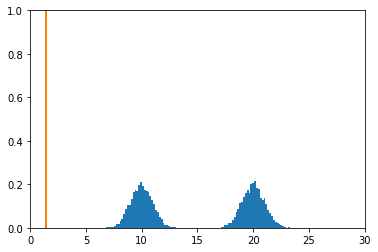

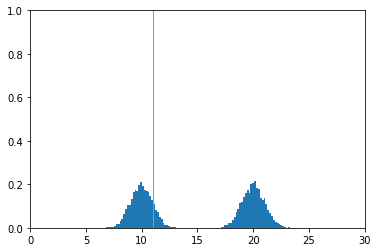

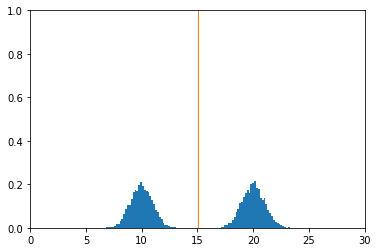

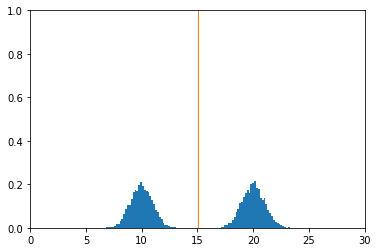

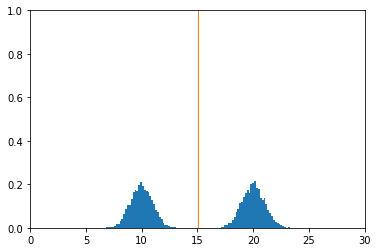

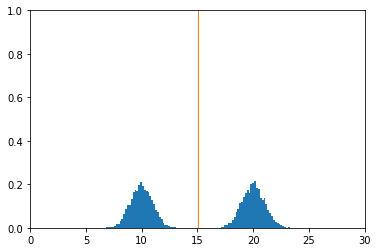

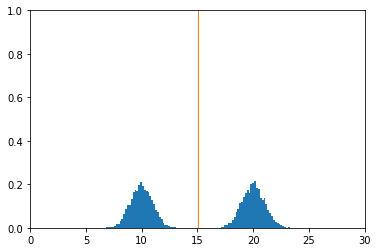

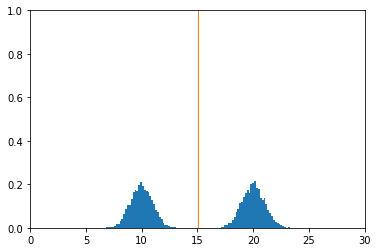

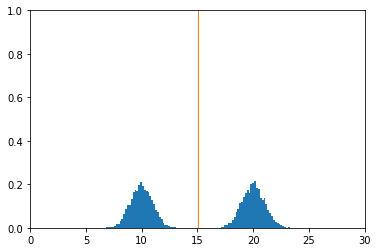

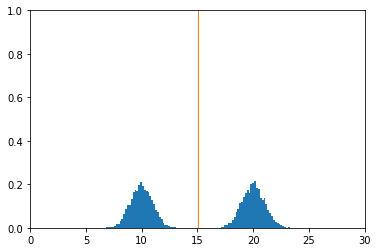

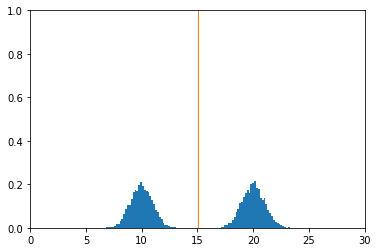

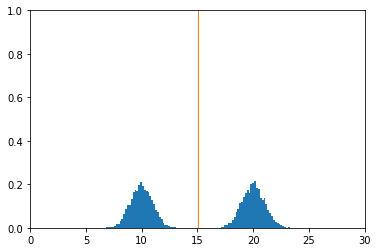

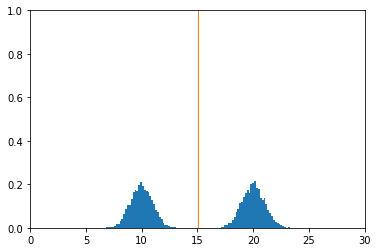

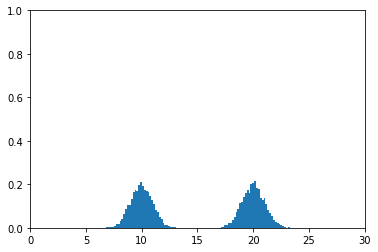

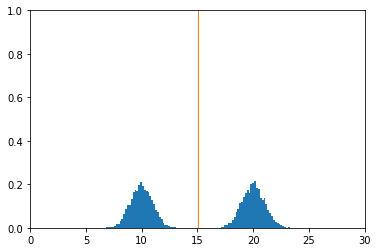

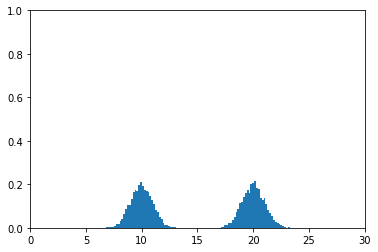

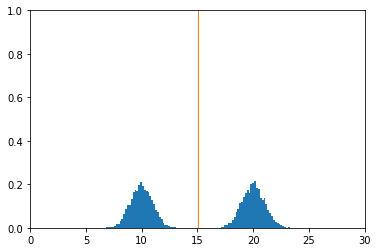

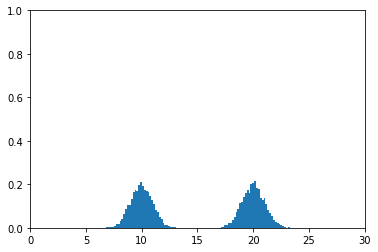

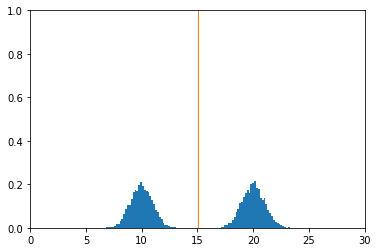

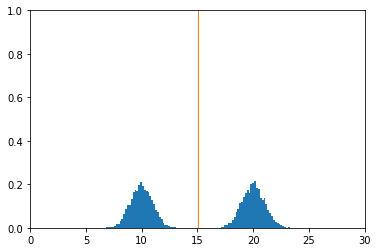

In [58]:
train_and_test(standard_criterion)

In [59]:
model = get_new_model()

Epoch 0 loss:11259.235 predicts(mean):0.943657
Epoch 5 loss:3736.410 predicts(mean):10.611887
Epoch 10 loss:1195.185 predicts(mean):15.000179
Epoch 15 loss:1195.217 predicts(mean):14.998014
Epoch 20 loss:1195.220 predicts(mean):14.997821
Epoch 25 loss:1195.220 predicts(mean):14.997802
Epoch 30 loss:1195.220 predicts(mean):14.997802
Epoch 35 loss:1195.220 predicts(mean):14.997802
Epoch 40 loss:1195.220 predicts(mean):14.997802
Epoch 45 loss:1195.220 predicts(mean):14.997803
Epoch 50 loss:1195.220 predicts(mean):14.997803
Epoch 55 loss:1195.220 predicts(mean):14.997803
Epoch 60 loss:1195.220 predicts(mean):14.997803
Epoch 65 loss:1195.220 predicts(mean):14.997802
Epoch 70 loss:1195.220 predicts(mean):14.997803
Epoch 75 loss:1195.220 predicts(mean):14.997804
Epoch 80 loss:1195.220 predicts(mean):14.997804
Epoch 85 loss:1195.220 predicts(mean):14.997804
Epoch 90 loss:1195.220 predicts(mean):14.997804
Epoch 95 loss:1195.220 predicts(mean):14.997804


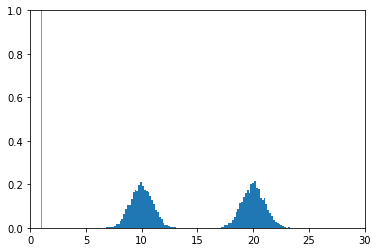

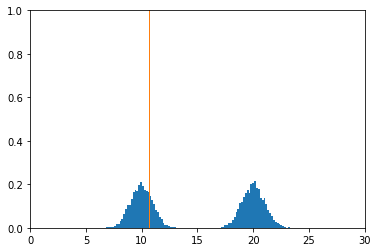

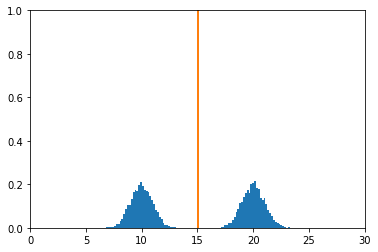

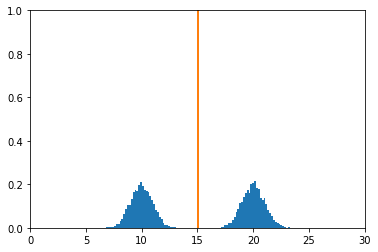

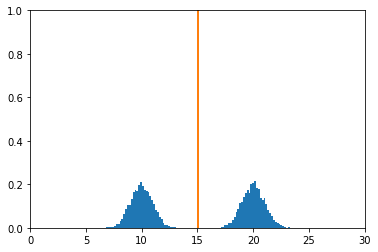

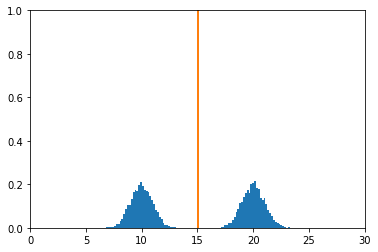

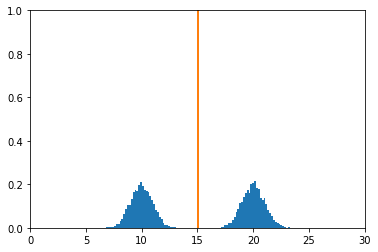

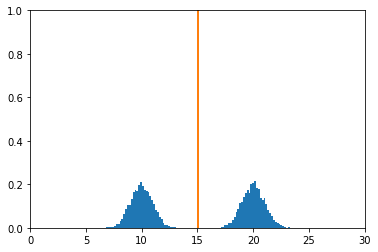

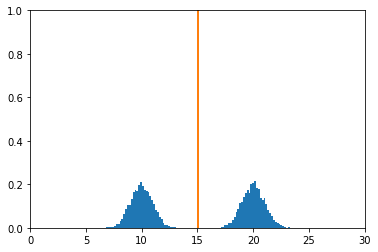

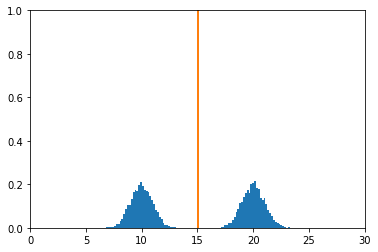

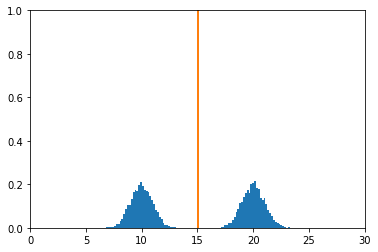

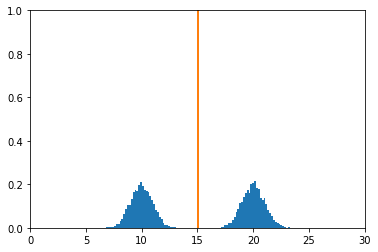

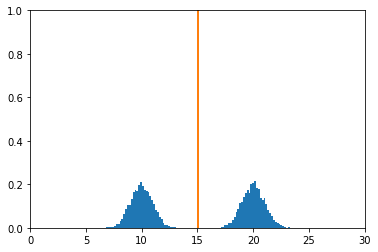

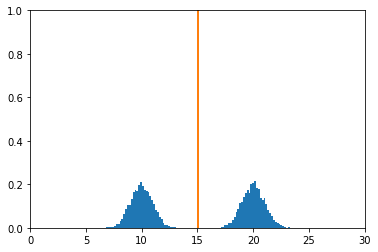

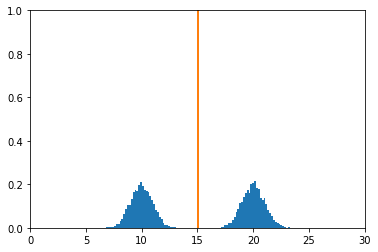

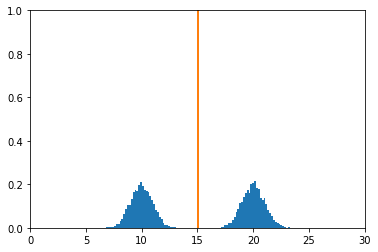

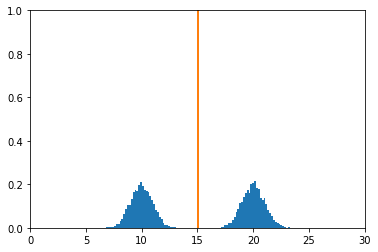

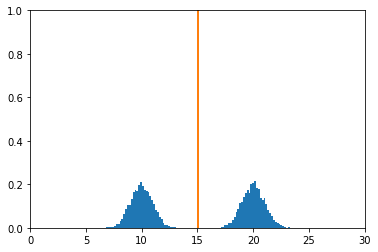

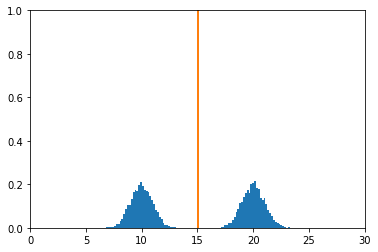

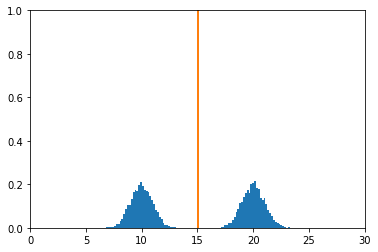

In [60]:
train_and_test(sum_criterion)